## Содержание
1. [Получение данных](#read_data)
2. [Изучение и подготовка данных](#data_processing)
3. [Анализ данных](#analysis)
4. [Проверка гипотез](#hypothesis_testing)
5. [Общий вывод](#conclusion)

# Определение перспективного тарифа для телеком-компании

Исследование проводится для компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

**Цель исследования:** определить, какой тариф приносит больше денег, чтобы скорректировать рекламный бюджет.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.
    
**Описание данных:**

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Шаг 1. Получение данных
<a name='read_data'></a>

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

# Шаг 2. Изучение и подготовка данных
<a name='data_processing'></a>

**Изучим таблицу с информацией о звонках:**

In [3]:
display(calls.head(3))

calls.info()

display(calls.describe().T)

calls.isna().sum()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


id           0
call_date    0
duration     0
user_id      0
dtype: int64

Данные, требующие обработки:

- Тип данных столбца call_date необходимо привести к формату datetime.
- Тип данных колонки duration - привести к целочисленному виду, округлив минуты в бОльшую сторону, т.к. «Мегалайн» всегда округляет секунды до минут в бОльшую сторону.

In [4]:
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].head()

0   2018-07-25
1   2018-08-17
2   2018-06-11
3   2018-09-21
4   2018-12-15
Name: call_date, dtype: datetime64[ns]

In [5]:
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000


Заменим звонки с нулевой продолжительностью на 1, т.к. «Мегалайн» всегда округляет вверх значения минут.

In [6]:
calls.loc[calls['duration'] == 0, 'duration'] = 1
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,1,1000
1,1000_1,2018-08-17,1,1000
2,1000_2,2018-06-11,3,1000


Посчитаем для каждого пользователя **количество сделанных звонков и израсходованных минут разговора по месяцам**. Для этого создаем столбец с номерами месяцев методом dt.month, а потом группируем и считаем данные посредством pivot_table.

In [7]:
calls['month'] = calls['call_date'].dt.month
calls.head(2)

calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration',  aggfunc=['count', 'sum'])
calls_pivot.columns = ['calls_count', 'calls_duration']

calls_pivot.head()

calls_count  calls_duration
user_id month                             
1000    5               22             164
        6               43             187
        7               47             346
        8               52             418
        9               58             478

**Информация об интернет-сессиях:**

In [8]:
display(internet.head(3))

internet.info()

display(internet.describe().T)

internet.isna().sum()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,count,mean,std,min,25%,50%,75%,max
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Данные, требующие обработки:

- Тип данных столбца session_date необходимо привести к формату datetime.
- Тип данных колонки mb_used - привести к целочисленному виду, округлив мегабайты в бОльшую сторону, т.к. «Мегалайн» также округляет их таким образом.

In [9]:
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].head()

0   2018-11-25
1   2018-09-07
2   2018-06-25
3   2018-08-22
4   2018-09-24
Name: session_date, dtype: datetime64[ns]

In [10]:
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')
display(internet.head(3))
internet['mb_used'].value_counts().head(3)

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000


0      19598
333      231
382      228
Name: mb_used, dtype: int64

Метод value_counts() показал, что в столбце mb_used очень много нулей. Так же заменим их на 1, т.к. «Мегалайн» всегда округляет вверх и объем веб-трафика тоже.

In [11]:
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1
internet['mb_used'].value_counts().head(3)

1      19700
333      231
382      228
Name: mb_used, dtype: int64

Посчитаем для каждого пользователя **объем израсходованного интернет-трафика по месяцам:**

In [12]:
internet['month'] = internet['session_date'].dt.month
internet.head(2)

internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_pivot.columns = ['mb_used_monthly']

internet_pivot.head()

mb_used_monthly
user_id month                 
1000    5                 2257
        6                23262
        7                14017
        8                14072
        9                14583

**Информация о сообщениях:**

In [13]:
display(messages.head(3))

messages.info()

display(messages.describe().T)

messages.isna().sum()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


id              0
message_date    0
user_id         0
dtype: int64

Данные, требующие обработки:

- Тип данных столбца message_date необходимо привести к формату datetime.

In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'].head()

0   2018-06-27
1   2018-10-08
2   2018-08-04
3   2018-06-16
4   2018-12-05
Name: message_date, dtype: datetime64[ns]

Посчитаем для каждого пользователя **количество отправленных сообщений по месяцам:**

In [15]:
messages['month'] = messages['message_date'].dt.month
messages.head(2)

messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_pivot.columns = ['messages_count']

messages_pivot.head()

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

**Информация о тарифах:**

In [16]:
display(tariffs.head(3))

tariffs.info()

display(tariffs.describe().T)

tariffs.isna().sum()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

**Информация о пользователях:**

In [17]:
display(users.head(3))

users.info()

display(users.describe().T)

users.isna().sum()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Данные, требующие обработки:

- Тип данных колонок churn_date и reg_date необходимо привести к формату datetime.
- Есть пропуски в столбце churn_date. Это связано с тем, что тариф еще действовал на момент выгрузки данных. Оставим пропуски.

In [18]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

users.info()
users.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


Для произведения необходимых расчетов необходимо **соединить таблицы в одну.**

Сначала **объединим** все таблицы pivot методом join(), которым можно объединять больше двух таблиц, передав их списком и сбросив индексы, которые были у сводных таблиц. Получаем таблицу data_pivot.

In [19]:
m_i_pivot = [messages_pivot, internet_pivot]

data_pivot = calls_pivot.join(m_i_pivot, how='outer')

data_pivot.reset_index(inplace=True)

data_pivot.head(15)

,user_id,month,calls_count,calls_duration,messages_count,mb_used_monthly
0,1000,5,22.0,164.0,22.0,2257.0
1,1000,6,43.0,187.0,60.0,23262.0
2,1000,7,47.0,346.0,75.0,14017.0
3,1000,8,52.0,418.0,81.0,14072.0
4,1000,9,58.0,478.0,57.0,14583.0
5,1000,10,57.0,363.0,73.0,14717.0
6,1000,11,43.0,344.0,58.0,14769.0
7,1000,12,46.0,341.0,70.0,9829.0
8,1001,11,59.0,444.0,NaN,18460.0
9,1001,12,63.0,430.0,NaN,14059.0


**Присоединим** полученную таблицу data_pivot к таблице users:

In [20]:
data = users.merge(data_pivot, how='outer')
data.head(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,164.0,22.0,2257.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,187.0,60.0,23262.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,346.0,75.0,14017.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,418.0,81.0,14072.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,478.0,57.0,14583.0
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,57.0,363.0,73.0,14717.0
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,43.0,344.0,58.0,14769.0
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,46.0,341.0,70.0,9829.0
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.0,59.0,444.0,NaN,18460.0
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.0,63.0,430.0,NaN,14059.0


Теперь **присоединим** таблицу tariffs.

Общей у 2-х таблиц является колонка с тарифами, но названия у них разные. Поэтому прежде переименуем столбец tariff_name на tariff.

In [21]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [22]:
data = data.merge(tariffs, how='outer')
data.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,164.0,22.0,2257.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,187.0,60.0,23262.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,346.0,75.0,14017.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,418.0,81.0,14072.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,478.0,57.0,14583.0,1000,30720,3000,1950,150,1,1
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.0,57.0,363.0,73.0,14717.0,1000,30720,3000,1950,150,1,1
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.0,43.0,344.0,58.0,14769.0,1000,30720,3000,1950,150,1,1
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.0,46.0,341.0,70.0,9829.0,1000,30720,3000,1950,150,1,1
8,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8.0,55.0,392.0,37.0,8572.0,1000,30720,3000,1950,150,1,1
9,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,9.0,134.0,990.0,91.0,12479.0,1000,30720,3000,1950,150,1,1


Удалим столбцы с инфомацией, которая не понадобится нам в работе:

In [23]:
data.drop(['age', 'first_name', 'last_name'], axis=1, inplace=True)

data.head(3)

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,NaT,Краснодар,2018-05-25,ultra,5.0,22.0,164.0,22.0,2257.0,1000,30720,3000,1950,150,1,1
1,1000,NaT,Краснодар,2018-05-25,ultra,6.0,43.0,187.0,60.0,23262.0,1000,30720,3000,1950,150,1,1
2,1000,NaT,Краснодар,2018-05-25,ultra,7.0,47.0,346.0,75.0,14017.0,1000,30720,3000,1950,150,1,1


Проверим новую таблицу на наличие пропусков:

In [24]:
data.isna().sum()

user_id                     0
churn_date               3027
city                        0
reg_date                    0
tariff                      0
month                       2
calls_count                42
calls_duration             42
messages_count            499
mb_used_monthly            13
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Итак, пропуски появились в следующих колонках: month, calls_count, calls_duration, messages_count, mb_used_monthly. Это может быть связано с тем, что клиенты могли не пользоваться всеми услугами связи в тот или иной месяц, т.ч. заменим пропуски нулями:

In [25]:
data['month'].fillna(0, inplace=True)
data['calls_count'].fillna(0, inplace=True)
data['calls_duration'].fillna(0, inplace=True)
data['messages_count'].fillna(0, inplace=True)
data['mb_used_monthly'].fillna(0, inplace=True)

In [26]:
data.isna().sum()

user_id                     0
churn_date               3027
city                        0
reg_date                    0
tariff                      0
month                       0
calls_count                 0
calls_duration              0
messages_count              0
mb_used_monthly             0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

Проверим, есть ли дубликаты и взглянем на количество строк:

In [27]:
data.duplicated().sum()

0

In [28]:
data.shape

(3216, 17)

Приведем следующие столбцы к целочисленному виду: month, calls_count, calls_duration, messages_count, mb_used_monthly.

In [29]:
data['month'] = data['month'].astype('int')
data['calls_count'] = data['calls_count'].astype('int')
data['calls_duration'] = data['calls_duration'].astype('int')
data['messages_count'] = data['messages_count'].astype('int')
data['mb_used_monthly'] = data['mb_used_monthly'].astype('int')

data

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,NaT,Краснодар,2018-05-25,ultra,5,22,164,22,2257,1000,30720,3000,1950,150,1,1
1,1000,NaT,Краснодар,2018-05-25,ultra,6,43,187,60,23262,1000,30720,3000,1950,150,1,1
2,1000,NaT,Краснодар,2018-05-25,ultra,7,47,346,75,14017,1000,30720,3000,1950,150,1,1
3,1000,NaT,Краснодар,2018-05-25,ultra,8,52,418,81,14072,1000,30720,3000,1950,150,1,1
4,1000,NaT,Краснодар,2018-05-25,ultra,9,58,478,57,14583,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,2018-10-25,Владикавказ,2018-07-19,smart,10,41,258,42,20614,50,15360,500,550,200,3,3
3212,1499,NaT,Пермь,2018-09-27,smart,9,9,71,11,1849,50,15360,500,550,200,3,3
3213,1499,NaT,Пермь,2018-09-27,smart,10,68,473,48,17824,50,15360,500,550,200,3,3
3214,1499,NaT,Пермь,2018-09-27,smart,11,74,624,59,17994,50,15360,500,550,200,3,3


**Посчитаем помесячную выручку с каждого пользователя** (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; умножить остаток на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).

Для этого напишем функции для звонков, сообщений и интернет-трафика и создадим соответствующие колонки. Не все пользователи превышают лимит тарифного пакета, поэтому, чтобы в колонках не получалось отрицательных значений, в функции указываем условие, чтобы она возвращала 0, если переплаты нет.

Затем посчитаем общую переплату за звонки, сообщения и трафик, и прибавим абонентскую плату по тарифу.

In [30]:
def calls_monthly_overpay(row):
    calls_duration = row['calls_duration']
    minutes_included = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    result =(calls_duration - minutes_included) * rub_per_minute
    if result <= 0:
        return 0
    return result

data['calls_monthly_overpay'] = data.apply(calls_monthly_overpay, axis=1)


def messages_monthly_overpay(row):
    messages_count = row['messages_count']
    messages_included = row['messages_included']
    rub_per_message = row['rub_per_message']
    result =(messages_count - messages_included) * rub_per_message
    if result <= 0:
        return 0
    return result

data['messages_monthly_overpay'] = data.apply(messages_monthly_overpay, axis=1)


def internet_monthly_overpay(row):
    mb_used_monthly = row['mb_used_monthly']
    mb_per_month_included = row['mb_per_month_included']
    rub_per_gb = row['rub_per_gb']
    result = np.ceil((mb_used_monthly - mb_per_month_included) / 1024) * rub_per_gb
    if result <= 0:
        return 0
    return result
    
data['internet_monthly_overpay'] = data.apply(internet_monthly_overpay, axis=1)
data['internet_monthly_overpay'] = data['internet_monthly_overpay'].astype('int')


data['overpay'] = data['calls_monthly_overpay'] + data['messages_monthly_overpay'] + data['internet_monthly_overpay']

data['total_income'] = data['overpay'] + data['rub_monthly_fee']

data

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_monthly_overpay,messages_monthly_overpay,internet_monthly_overpay,overpay,total_income
0,1000,NaT,Краснодар,2018-05-25,ultra,5,22,164,22,2257,...,3000,1950,150,1,1,0,0,0,0,1950
1,1000,NaT,Краснодар,2018-05-25,ultra,6,43,187,60,23262,...,3000,1950,150,1,1,0,0,0,0,1950
2,1000,NaT,Краснодар,2018-05-25,ultra,7,47,346,75,14017,...,3000,1950,150,1,1,0,0,0,0,1950
3,1000,NaT,Краснодар,2018-05-25,ultra,8,52,418,81,14072,...,3000,1950,150,1,1,0,0,0,0,1950
4,1000,NaT,Краснодар,2018-05-25,ultra,9,58,478,57,14583,...,3000,1950,150,1,1,0,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,2018-10-25,Владикавказ,2018-07-19,smart,10,41,258,42,20614,...,500,550,200,3,3,0,0,1200,1200,1750
3212,1499,NaT,Пермь,2018-09-27,smart,9,9,71,11,1849,...,500,550,200,3,3,0,0,0,0,550
3213,1499,NaT,Пермь,2018-09-27,smart,10,68,473,48,17824,...,500,550,200,3,3,0,0,600,600,1150
3214,1499,NaT,Пермь,2018-09-27,smart,11,74,624,59,17994,...,500,550,200,3,3,372,27,600,999,1549


# Шаг 3. Анализ данных
<a name='analysis'></a>

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построем гистограммы. Опишем распределения.

Сделаем 2 выборки по тарифам ultra и smart методом query:

**Тариф ULTRA:**

In [31]:
ultra = data.query('tariff == "ultra"')
ultra.head(3)

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_monthly_overpay,messages_monthly_overpay,internet_monthly_overpay,overpay,total_income
0,1000,NaT,Краснодар,2018-05-25,ultra,5,22,164,22,2257,...,3000,1950,150,1,1,0,0,0,0,1950
1,1000,NaT,Краснодар,2018-05-25,ultra,6,43,187,60,23262,...,3000,1950,150,1,1,0,0,0,0,1950
2,1000,NaT,Краснодар,2018-05-25,ultra,7,47,346,75,14017,...,3000,1950,150,1,1,0,0,0,0,1950


Взглянем на числовое описание данных и диаграмму размаха для колонки с **продолжительностью звонков:**

count     986.000000
mean      540.231237
std       326.028527
min         0.000000
25%       291.250000
50%       531.500000
75%       772.500000
max      1727.000000
Name: calls_duration, dtype: float64

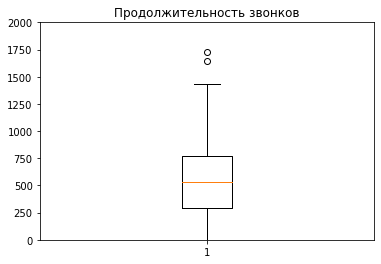

In [32]:
plt.boxplot(ultra['calls_duration'])
plt.ylim(0, 2000)
plt.title('Продолжительность звонков')

ultra['calls_duration'].describe()

Удалим отрицательные значения и выбросы и снова взглянем на числовое описание и график:

In [33]:
ultra = ultra.loc[(ultra['calls_duration'] > 0) & (ultra['calls_duration'] <= 1600)]
ultra = ultra.reset_index(drop=True)

count     949.000000
mean      557.738672
std       310.778937
min         1.000000
25%       318.000000
50%       543.000000
75%       776.000000
max      1437.000000
Name: calls_duration, dtype: float64

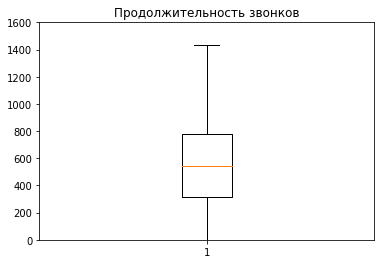

In [34]:
plt.boxplot(ultra['calls_duration'])
plt.ylim(0, 1600)
plt.title('Продолжительность звонков')

ultra['calls_duration'].describe()

Построим гистограмму для продолжительности звонков, чтобы оценить распределение:

Text(0.5, 0, 'calls_duration')

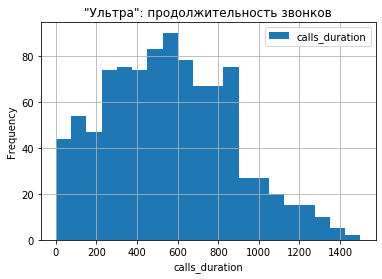

In [35]:
ultra.plot(y = 'calls_duration', kind = 'hist', bins = 20, grid = True, range = (1,1500), title='"Ультра": продолжительность звонков')
plt.xlabel('calls_duration')

Датасет скошен вправо: средняя продолжительность звонков по тарифу "Ультра" больше медианного.

То же проделаем для колонки с **количеством сообщений:**

count    949.000000
mean      49.074816
std       46.929470
min        0.000000
25%        5.000000
50%       39.000000
75%       79.000000
max      224.000000
Name: messages_count, dtype: float64

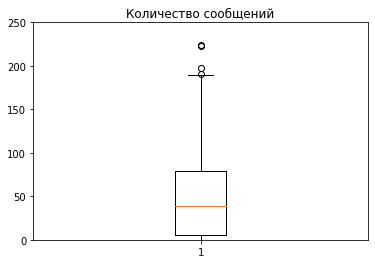

In [36]:
plt.boxplot(ultra['messages_count'])
plt.ylim(0, 250)
plt.title('Количество сообщений')

ultra['messages_count'].describe()

Удалим выбросы:

In [37]:
ultra = ultra.loc[(ultra['messages_count'] > 0) & (ultra['messages_count'] <= 200)]
ultra = ultra.reset_index(drop=True)

count    758.000000
mean      60.850923
std       44.017382
min        1.000000
25%       25.000000
50%       52.000000
75%       87.750000
max      197.000000
Name: messages_count, dtype: float64

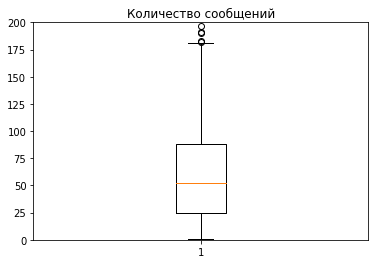

In [38]:
plt.boxplot(ultra['messages_count'])
plt.ylim(0, 200)
plt.title('Количество сообщений')

ultra['messages_count'].describe()

Построим гистограмму для количества сообщений:

Text(0.5, 0, 'messages_count')

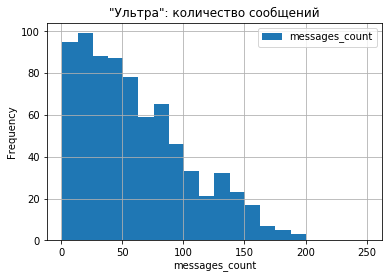

In [39]:
ultra.plot(y = 'messages_count', kind = 'hist', bins = 20, grid = True, range = (1,250), title='"Ультра": количество сообщений')
plt.xlabel('messages_count')

Датасет скошен вправо: сообщения пользователи "Ультра" пишут не очень часто.

Таким же образом поработаем над колонкой с **объёмом интернет-трафика:**

count      758.000000
mean     19372.299472
std       9823.085803
min          0.000000
25%      11677.250000
50%      19396.500000
75%      26789.750000
max      49793.000000
Name: mb_used_monthly, dtype: float64

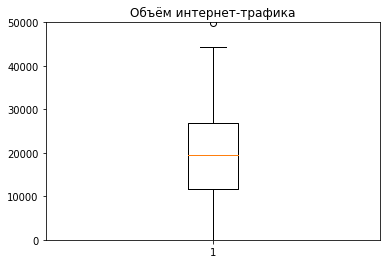

In [40]:
plt.boxplot(ultra['mb_used_monthly'])
plt.ylim(0, 50000)
plt.title('Объём интернет-трафика')

ultra['mb_used_monthly'].describe()

Удалим выбросы:

In [41]:
ultra = ultra.loc[(ultra['mb_used_monthly'] > 0) & (ultra['mb_used_monthly'] <= 50000)]
ultra = ultra.reset_index(drop=True)

count      748.000000
mean     19631.287433
std       9627.755804
min          1.000000
25%      12063.750000
50%      19465.000000
75%      26857.000000
max      49793.000000
Name: mb_used_monthly, dtype: float64

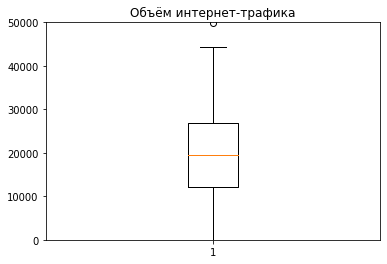

In [42]:
plt.boxplot(ultra['mb_used_monthly'])
plt.ylim(0, 50000)
plt.title('Объём интернет-трафика')

ultra['mb_used_monthly'].describe()

Гистограмма по объёму интернет-трафика:

Text(0.5, 0, 'mb_used_monthly')

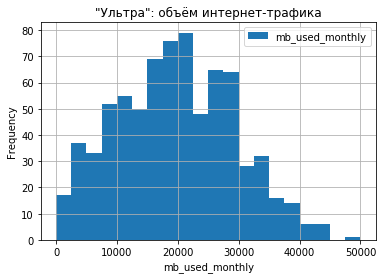

In [43]:
ultra.plot(y = 'mb_used_monthly', kind = 'hist', bins = 20, grid = True, range = (1,50000), title='"Ультра": объём интернет-трафика')
plt.xlabel('mb_used_monthly')

Распределение похоже на нормальное.

Посчитаем **среднее количество, дисперсию и стандартное отклонение** для тарифа "Ультра".

- для звонков:

*среднее:*

In [44]:
ultra_calls_mean = (ultra['calls_duration']).mean()
ultra_calls_mean

568.6991978609626

*дисперсия:*

In [45]:
ultra_calls_variance = np.var(ultra['calls_duration'], ddof=1)
ultra_calls_variance

99157.87057499158

*стандартное отклонение:*

In [46]:
ultra_calls_standard_deviation = np.std(ultra['calls_duration'], ddof=1)
ultra_calls_standard_deviation

314.89342732897995

- для сообщений:

*среднее:*

In [47]:
ultra_messages_mean = (ultra['messages_count']).mean()
ultra_messages_mean

61.294117647058826

*дисперсия:*

In [48]:
ultra_messages_variance = np.var(ultra['messages_count'], ddof=1)
ultra_messages_variance

1946.033860933932

*стандартное отклонение:*

In [49]:
ultra_messages_standard_deviation = np.std(ultra['messages_count'], ddof=1)
ultra_messages_standard_deviation

44.11387379197084

- для интернет-трафика:

*среднее:*

In [50]:
ultra_internet_mean = (ultra['mb_used_monthly']).mean()
ultra_internet_mean

19631.28743315508

*дисперсия:*

In [51]:
ultra_internet_variance = np.var(ultra['mb_used_monthly'], ddof=1)
ultra_internet_variance

92693681.83025686

*стандартное отклонение:*

In [52]:
ultra_internet_standard_deviation = np.std(ultra['mb_used_monthly'], ddof=1)
ultra_internet_standard_deviation

9627.755804457072

**Вывод:**

У пользователей тарифа "Ультра" на звонки в среднем уходит 570 минут в месяц. Среднее количество сообщений в месяц - 61. А объем интернет-трафика - 19 Гб.


In [53]:
ultra.shape

(748, 22)

**Тариф SMART:**

In [54]:
smart = data.query('tariff == "smart"')
smart.head(3)

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_monthly_overpay,messages_monthly_overpay,internet_monthly_overpay,overpay,total_income
986,1001,NaT,Москва,2018-11-01,smart,11,59,444,0,18460,...,500,550,200,3,3,0,0,800,800,1350
987,1001,NaT,Москва,2018-11-01,smart,12,63,430,0,14059,...,500,550,200,3,3,0,0,0,0,550
988,1002,NaT,Стерлитамак,2018-06-17,smart,6,15,118,4,10878,...,500,550,200,3,3,0,0,0,0,550


Посмотрим на числовое описание данных и диаграмму размаха для колонки с **продолжительностью звонков:**

count    2230.000000
mean      429.258296
std       195.039589
min         0.000000
25%       290.250000
50%       434.500000
75%       560.000000
max      1471.000000
Name: calls_duration, dtype: float64

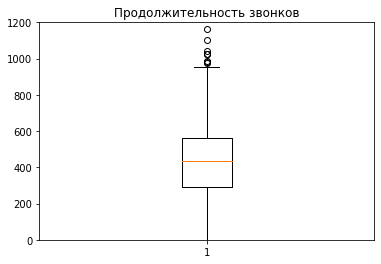

In [55]:
plt.boxplot(smart['calls_duration'])
plt.ylim(0, 1200)
plt.title('Продолжительность звонков')

smart['calls_duration'].describe()

Удалим выбросы и снова посмотрим на числовое описание и диаграмму:

In [56]:
smart = smart.loc[(smart['calls_duration'] > 0) & (smart['calls_duration'] <= 1100)]
smart = smart.reset_index(drop=True)

count    2220.000000
mean      429.507658
std       191.553939
min         1.000000
25%       292.000000
50%       435.000000
75%       560.000000
max      1044.000000
Name: calls_duration, dtype: float64

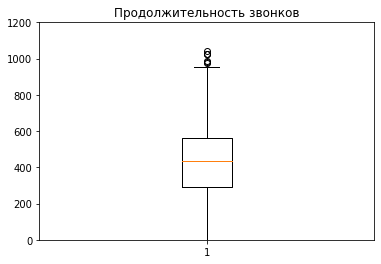

In [57]:
plt.boxplot(smart['calls_duration'])
plt.ylim(0, 1200)
plt.title('Продолжительность звонков')

smart['calls_duration'].describe()

Построим гистограмму для продолжительности звонков для оценки распределения:

Text(0.5, 0, 'calls_duration')

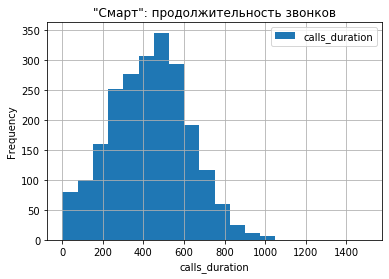

In [58]:
smart.plot(y = 'calls_duration', kind = 'hist', bins = 20, grid = True, range = (1,1500), title='"Смарт": продолжительность звонков')
plt.xlabel('calls_duration')

Распределение близко к нормальному: среднее и медиана почти одинаковы.

**Количество сообщений:**

count    2220.000000
mean       33.380180
std        28.267833
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_count, dtype: float64

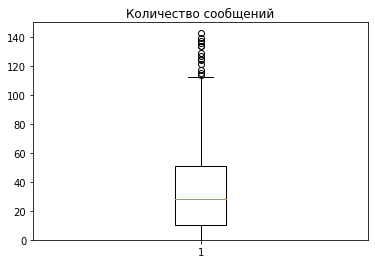

In [59]:
plt.boxplot(smart['messages_count'])
plt.ylim(0, 150)
plt.title('Количество сообщений')

smart['messages_count'].describe()

Удаляем выбросы:

In [60]:
smart = smart.loc[(smart['messages_count'] > 0) & (smart['messages_count'] <= 120)]
smart = smart.reset_index(drop=True)

count    1902.000000
mean       38.199264
std        25.948757
min         1.000000
25%        17.000000
50%        33.000000
75%        55.000000
max       117.000000
Name: messages_count, dtype: float64

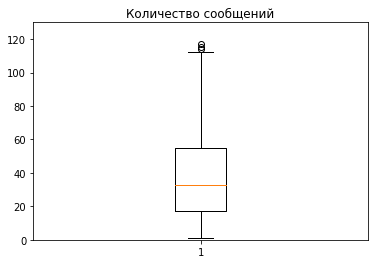

In [61]:
plt.boxplot(smart['messages_count'])
plt.ylim(0, 130)
plt.title('Количество сообщений')

smart['messages_count'].describe()

Построим гистограмму для количества сообщений:

Text(0.5, 0, 'messages_count')

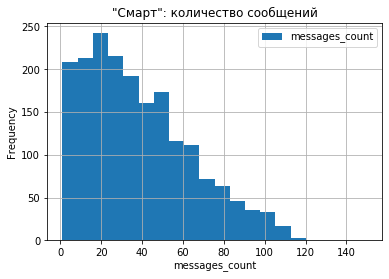

In [62]:
smart.plot(y = 'messages_count', kind = 'hist', bins = 20, grid = True, range = (1,150), title='"Смарт": количество сообщений')
plt.xlabel('messages_count')

Датасет скошен вправо: пользователи тарифа "Смарт" так же нечасто отправляют сообщения.

**Объём интернет-трафика:**

count     1902.000000
mean     16224.585174
std       5801.120723
min          0.000000
25%      12639.250000
50%      16432.500000
75%      20030.500000
max      38627.000000
Name: mb_used_monthly, dtype: float64

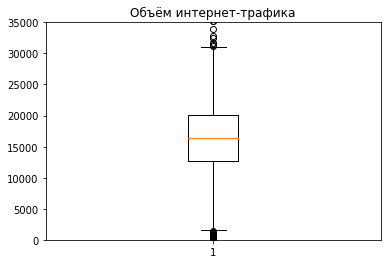

In [63]:
plt.boxplot(smart['mb_used_monthly'])
plt.ylim(0, 35000)
plt.title('Объём интернет-трафика')

smart['mb_used_monthly'].describe()

Удалим выбросы:

In [64]:
smart = smart.loc[(smart['mb_used_monthly'] > 0) & (smart['mb_used_monthly'] <= 33000)]
smart = smart.reset_index(drop=True)

count     1894.000000
mean     16159.500000
std       5672.376884
min          1.000000
25%      12628.500000
50%      16396.000000
75%      19993.500000
max      32793.000000
Name: mb_used_monthly, dtype: float64

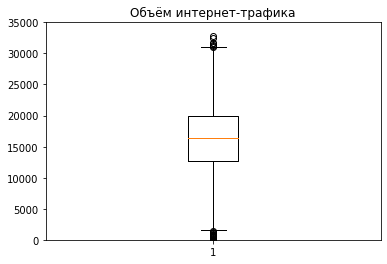

In [65]:
plt.boxplot(smart['mb_used_monthly'])
plt.ylim(0, 35000)
plt.title('Объём интернет-трафика')

smart['mb_used_monthly'].describe()

Гистограмма по объёму интернет-трафика:

Text(0.5, 0, 'mb_used_monthly')

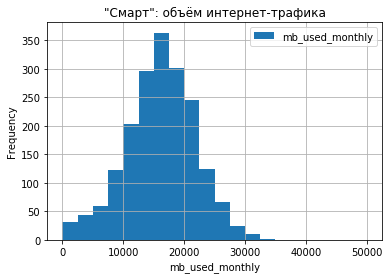

In [66]:
smart.plot(y = 'mb_used_monthly', kind = 'hist', bins = 20, grid = True, range = (1,50000), title='"Смарт": объём интернет-трафика')
plt.xlabel('mb_used_monthly')

Распределение нормальное: среднее и медиана очень близки.

Посчитаем **среднее количество, дисперсию и стандартное отклонение** для тарифа "Смарт".

- для звонков:

*среднее:*

In [67]:
smart_calls_mean = (smart['calls_duration']).mean()
smart_calls_mean

429.0052798310454

*дисперсия:*

In [68]:
smart_calls_variance = np.var(smart['calls_duration'], ddof=1)
smart_calls_variance

35396.6011342851

*стандартное отклонение:*

In [69]:
smart_calls_standard_deviation = np.std(smart['calls_duration'], ddof=1)
smart_calls_standard_deviation

188.1398446217204

- для сообщений:

*среднее:*

In [70]:
smart_messages_mean = (smart['messages_count']).mean()
smart_messages_mean

38.1805702217529

*дисперсия:*

In [71]:
smart_messages_variance = np.var(smart['messages_count'], ddof=1)
smart_messages_variance

669.7486766952777

*стандартное отклонение:*

In [72]:
smart_messages_standard_deviation = np.std(smart['messages_count'], ddof=1)
smart_messages_standard_deviation

25.879503022571313

- для интернет-трафика:

*среднее:*

In [73]:
smart_internet_mean = (smart['mb_used_monthly']).mean()
smart_internet_mean

16159.5

*дисперсия:*

In [74]:
smart_internet_variance = np.var(smart['mb_used_monthly'], ddof=1)
smart_internet_variance

32175859.516904384

*стандартное отклонение:*

In [75]:
smart_internet_standard_deviation = np.std(smart['mb_used_monthly'], ddof=1)
smart_internet_standard_deviation

5672.376884243887

**Вывод:**

У пользователей тарифа "Смарт" на звонки в среднем уходит 430 минут в месяц. Среднее количество сообщений в месяц - 38. А объем интернет-трафика - 16 Гб.

В сравнении с тарифом "Ультра", у тарифа "Смарт" эти показатели меньше.

In [76]:
smart.shape

(1894, 22)

Построим **графики для тарифа "Ультра" и "Смарт"** на одном рисунке:

- продолжительность звонков:

Text(0.5, 0, 'calls_duration')

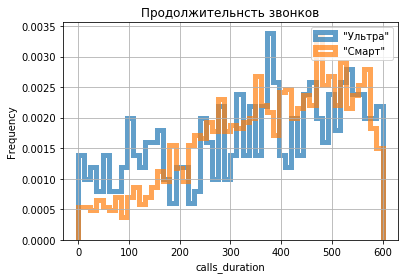

In [77]:
ax = ultra.plot(
    kind='hist',
    y='calls_duration',
    histtype='step',
    range=(0, 600),
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='"Ультра"',
    title='Продолжительнсть звонков',
    density=True
)
smart.plot(
    kind='hist',
    y='calls_duration',
    histtype='step',
    range=(0, 600),
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='"Смарт"',
    ax=ax,
    grid=True,
    legend=True,
    density=True
)
plt.xlabel('calls_duration')

**Вывод:** пользователи тарифа "Смарт" больше всего используют его для более долгих разговоров. Пользователи тарифа "Ультра" используют этот тариф для звонков чаще тех, у кого подключен "Смарт".

- количество сообщений:

Text(0.5, 0, 'messages_count')

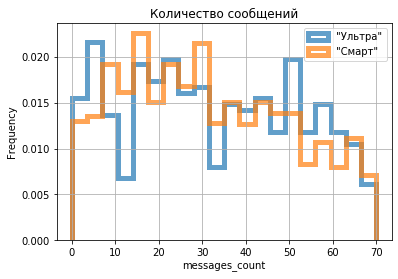

In [78]:
ax = ultra.plot(
    kind='hist',
    y='messages_count',
    histtype='step',
    range=(0, 70),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='"Ультра"',
    title='Количество сообщений',
    density=True
)
smart.plot(
    kind='hist',
    y='messages_count',
    histtype='step',
    range=(0, 70),
    bins=20,
    linewidth=5,
    alpha=0.7,
    label='"Смарт"',
    ax=ax,
    grid=True,
    legend=True,
    density=True
)
ax.set_xlabel('messages_count')

**Вывод:** пользователи тарифа "Ультра" пишут больше сообщений.

- объем интернет-трафика:

Text(0.5, 0, 'mb_used_monthly')

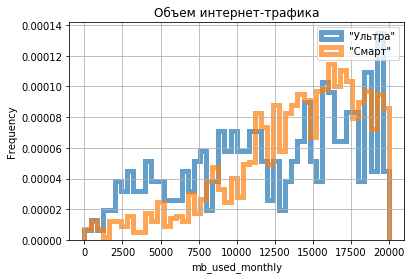

In [79]:
ax = ultra.plot(
    kind='hist',
    y='mb_used_monthly',
    histtype='step',
    range=(0, 20000),
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='"Ультра"',
    title='Объем интернет-трафика',
    density=True
)
smart.plot(
    kind='hist',
    y='mb_used_monthly',
    histtype='step',
    range=(0, 20000),
    bins=50,
    linewidth=5,
    alpha=0.7,
    label='"Смарт"',
    ax=ax,
    grid=True,
    legend=True,
    density=True
)
ax.set_xlabel('mb_used_monthly')

**Вывод:** пользователи тарифа "Ультра" чаще пользуются интернетом. Пользователи тарифа "Смарт" используют его для более продолжительных интернет-сессий.

- переплата:

Text(0.5, 0, 'overpay')

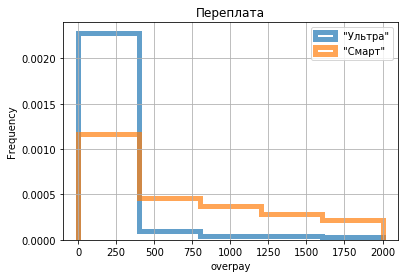

In [80]:
ax = ultra.plot(
    kind='hist',
    y='overpay',
    histtype='step',
    range=(0, 2000),
    bins=5,
    linewidth=5,
    alpha=0.7,
    label='"Ультра"',
    title='Переплата',
    density=True
)
smart.plot(
    kind='hist',
    y='overpay',
    histtype='step',
    range=(0, 2000),
    bins=5,
    linewidth=5,
    alpha=0.7,
    label='"Смарт"',
    ax=ax,
    grid=True,
    legend=True,
    density=True
)
plt.xlabel('overpay')

**Вывод:** пользователи тарифа "Ультра" чаще тратят сверх тарифного пакета, но небольшие суммы, в то время как пользователи тарифа "Смарт" тратят более крупные суммы чаще, чем первые.

- выручка с каждого тарифа:

Text(0.5, 0, 'total_income')

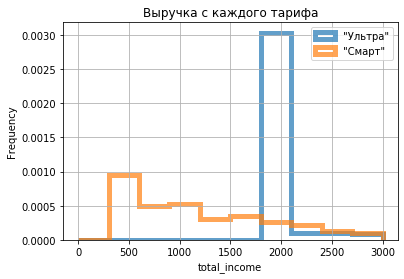

In [81]:
ax = ultra.plot(
    kind='hist',
    y='total_income',
    histtype='step',
    range=(0, 3000),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='"Ультра"',
    title='Выручка с каждого тарифа',
    density=True
)
smart.plot(
    kind='hist',
    y='total_income',
    histtype='step',
    range=(0, 3000),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='"Смарт"',
    ax=ax,
    grid=True,
    legend=True,
    density=True
)
plt.xlabel('total_income')

**Вывод:** пользователи тарифа "Ультра", вероятно, приносят больше выручки за счет более дорогой стоимости тарифа.

Выводим статистику по всем значениям для обоих тарифов:

In [82]:
data.pivot_table(index='tariff', values=['calls_duration', 'messages_count', 'mb_used_monthly'],
                       aggfunc=['mean', 'std', 'var'])

mean                                           std  \
       calls_duration mb_used_monthly messages_count calls_duration   
tariff                                                                
smart      429.258296    16229.903139      33.369058     195.039589   
ultra      540.231237    19468.938134      49.313387     326.028527   

                                                 var                  \
       mb_used_monthly messages_count calls_duration mb_used_monthly   
tariff                                                                 
smart      5888.523413      28.230396   38040.441104    3.467471e+07   
ultra     10111.047371      47.806040  106294.600282    1.022333e+08   

                       
       messages_count  
tariff                 
smart      796.955256  
ultra     2285.417425

# Шаг 4. Проверка гипотез
<a name='hypothesis_testing'></a>

Гипотезы:

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

В данном случае нам необходимо сравнить между собой 2 похожие выборки по тарифам и по регионам. 

Нулевая гипотеза H₀: исследуемые совокупности равны.

Альтернативная гипотеза H₁: исследуемые совокупности не равны.

Это гипотезы о равенстве средних двух генеральных совокупностей, для проверки которых используем метод scipy.stats.ttest_ind.

*Проверим первую гипотезу:*

In [83]:
ultra_total_income = ultra['total_income']
smart_total_income = smart['total_income']

alpha = 0.05
results = st.ttest_ind(ultra_total_income, smart_total_income)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 3.503159450377682e-132
Отвергаем нулевую гипотезу


Средняя выручка по тарифу "Ультра":

In [84]:
ultra_total_income.mean().round()


2050.0

Средняя выручка по тарифу "Смарт":

In [85]:
smart_total_income.mean().round()

1286.0

**Вывод:** средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Выручка бюджетного тарифа не достигает даже абонентской платы дорогого тарифа.

*Проверим вторую гипотезу:*

**Объединим** очищенные от выбросов таблицы с тарифами:

In [86]:
ultra_smart = ultra.merge(smart, how='outer')
data

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_monthly_overpay,messages_monthly_overpay,internet_monthly_overpay,overpay,total_income
0,1000,NaT,Краснодар,2018-05-25,ultra,5,22,164,22,2257,...,3000,1950,150,1,1,0,0,0,0,1950
1,1000,NaT,Краснодар,2018-05-25,ultra,6,43,187,60,23262,...,3000,1950,150,1,1,0,0,0,0,1950
2,1000,NaT,Краснодар,2018-05-25,ultra,7,47,346,75,14017,...,3000,1950,150,1,1,0,0,0,0,1950
3,1000,NaT,Краснодар,2018-05-25,ultra,8,52,418,81,14072,...,3000,1950,150,1,1,0,0,0,0,1950
4,1000,NaT,Краснодар,2018-05-25,ultra,9,58,478,57,14583,...,3000,1950,150,1,1,0,0,0,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,2018-10-25,Владикавказ,2018-07-19,smart,10,41,258,42,20614,...,500,550,200,3,3,0,0,1200,1200,1750
3212,1499,NaT,Пермь,2018-09-27,smart,9,9,71,11,1849,...,500,550,200,3,3,0,0,0,0,550
3213,1499,NaT,Пермь,2018-09-27,smart,10,68,473,48,17824,...,500,550,200,3,3,0,0,600,600,1150
3214,1499,NaT,Пермь,2018-09-27,smart,11,74,624,59,17994,...,500,550,200,3,3,372,27,600,999,1549


In [87]:
ultra_smart.shape

(2642, 22)

Сделаем категоризацию по регионам и создадим столбец.

In [88]:
def region_category(city):
    if city == 'Москва':
        return 'Москва'
    return 'другой регион'

ultra_smart['region_category'] = ultra_smart['city'].apply(region_category)
ultra_smart.head(2)

,user_id,churn_date,city,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_monthly,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_monthly_overpay,messages_monthly_overpay,internet_monthly_overpay,overpay,total_income,region_category
0,1000,NaT,Краснодар,2018-05-25,ultra,5,22,164,22,2257,...,1950,150,1,1,0,0,0,0,1950,другой регион
1,1000,NaT,Краснодар,2018-05-25,ultra,6,43,187,60,23262,...,1950,150,1,1,0,0,0,0,1950,другой регион


Протестируем гипотезу по выборкам по регионам:

In [89]:
moscow = ultra_smart.loc[(ultra_smart['region_category'] == 'Москва'), 'total_income']
other_region = ultra_smart.loc[(ultra_smart['region_category'] == 'другой регион'), 'total_income']

alpha = 0.05
results = st.ttest_ind(moscow, other_region)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.06120618570981325
Не получилось отвергнуть нулевую гипотезу


Средняя выручка по Москве:

In [90]:
moscow.mean().round()

1560.0

Средняя выручка по другим регионам:

In [91]:
other_region.mean().round()

1489.0

**Вывод:** средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

# Шаг 5. Oбщий вывод
<a name='conclusion'></a>

**Звонки:**

У пользователей тарифа " Ультра " на звонки в среднем уходит 570 минут в месяц, у пользователей тарифа "Смарт" - 430 минут в месяц.

Средняя продолжительность звонков по тарифу "Ультра" больше медианного.

Среднее и медиана звонков по тарифу «Смарт» почти одинаковы.

Пользователи тарифа "Смарт" больше всего используют его для более долгих разговоров.

Тариф "Ультра" используют для звонков чаще тех, у кого подключен "Смарт".

**Сообщения:**

У пользователей тарифа " Ультра " среднее количество сообщений в месяц – 61, а у пользователей тарифа "Смарт" - 38.

Пользователи тарифа "Ультра" пишут больше сообщений, чем те, у кого "Смарт", но все равно не часто.

**Интернет:**

У пользователей тарифа " Ультра " средний объем интернет-трафика - 19 Гб, а у пользователей тарифа "Смарт" - 16 Гб.

Пользователи тарифа "Ультра" чаще пользуются интернетом. А те, у кого подключен "Смарт", используют его для более продолжительных интернет-сессий.

Среднее и медиана по объёму интернет-трафика у обоих тарифов очень близки.

**Переплата:**

Пользователи тарифа "Ультра" чаще тратят сверх тарифного пакета, но небольшие суммы, в то время как пользователи тарифа "Смарт" тратят более крупные суммы чаще, чем первые.

**Средняя выручка по тарифам:**

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:
- по тарифу "Ультра": 2050 руб.,
- по тарифу "Смарт": 1286 руб.

**Средняя выручка по городам:**

Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов:
- по Москве: 1560 руб.
- по другим регионам: 1489 руб.

**Итоги исследования:**

Судя по продолжительности звонков и количеству сообщений, пользователи тарифа "Смарт" стараются не превышать лимит, в то время как те, у кого подключен «Ультра», звонят и отправляют сообщений столько, сколько им необходимо, что превысило бы лимиты тарифа "Смарт". Причем пользователям "Смарт" немного не хватает лимита интернет-трафика.

Выручка с тарифа «Ультра» так же больше.

Возможно, еще один тариф с усредненными параметрами пришелся бы клиентам в самый раз.